In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import torch

model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

img = Image.open("perros.jpg")
x = transform(img).unsqueeze(0)

with torch.no_grad():
    preds = model(x)

print(preds)

[{'boxes': tensor([[ 27.4293,  39.8756,  89.6044, 234.6432],
        [196.0012,  43.9663, 274.7581, 263.5038],
        [113.3479,  32.0600, 183.4961, 267.2658],
        [111.1046,  32.9752, 179.4572, 268.9831],
        [149.6283,  34.9471, 202.6248, 223.5264],
        [170.9982, 161.6701, 186.4849, 204.1463],
        [ 26.3370,  49.2710,  83.3346, 146.7235],
        [200.5964,  44.6974, 229.3510,  85.2150],
        [177.6669, 197.9514, 186.5189, 244.9245],
        [159.3689,  43.3585, 278.0357, 122.5505],
        [193.4877,  37.3119, 276.0383, 260.8489],
        [105.9792, 251.5278, 125.6121, 268.6343],
        [194.6857,  48.2807, 219.4292,  92.0385],
        [111.3457,  79.2720, 181.3416, 269.8240],
        [177.1606, 213.9436, 186.4375, 264.0661],
        [197.6516,  53.3356, 209.6911,  88.6888],
        [104.0620, 230.1367, 130.2032, 268.0432],
        [204.4172,  47.3187, 220.7764,  79.3651],
        [181.0067, 162.5449, 190.7924, 202.7131],
        [172.6626,  92.4898, 202.2358, 

SSD: 2.321857213973999 seg


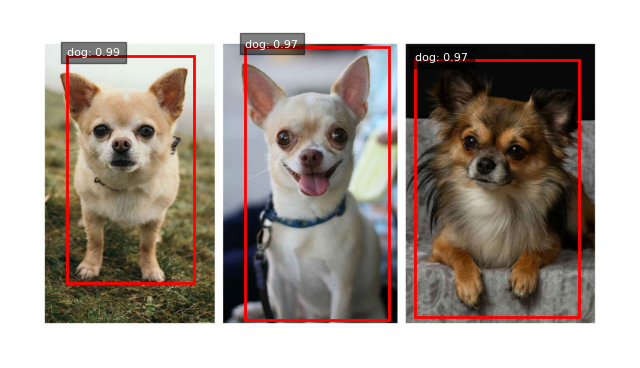

In [3]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import time

# Cargar SSD300-VGG16 con pesos preentrenados por defecto (COCO) y ponerlo en modo evaluación para inferencia
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights).eval()

# Transforms correctos (no redimensionan fijo a 300x300, se encargan de escalar de forma consistente). Prepara la imagen igual que durante el entrenamiento (resize, normalización, etc.) para que el modelo la entienda bien
preprocess = weights.transforms()

# Imagen
img = Image.open("perros.jpg").convert("RGB")

# Convierte la imagen en un tensor preprocesado y le agrega la dimensión de batch (1 imagen)
x = preprocess(img).unsqueeze(0)

# Ejecuta el modelo en modo inferencia (sin gradientes) y obtiene las predicciones de la única imagen del batch
with torch.no_grad():
    t0 = time.time()  
    out = model(x)[0]  
    t1 = time.time()  
  
print("SSD:", t1-t0, "seg")

# Boxes ya están en escala original 🎉
boxes, labels, scores = out["boxes"], out["labels"], out["scores"]

# Lista de nombres de clases (COCO) que corresponde a los índices de 'labels' en las predicciones
categories = weights.meta["categories"]

# Visualizar
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.imshow(img)
for box, lab, sc in zip(boxes, labels, scores):
    if sc > 0.5:  # filtrar confianza
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1, f"{categories[int(lab)]}: {sc:.2f}",
                color="white", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5))
plt.axis("off")
plt.show()

In [5]:
from ultralytics import YOLO

model_yolo = YOLO("yolov8n.pt")
results = model_yolo("perros.jpg")


image 1/1 c:\Users\Sebas\Desktop\Codelabs-Proyecto-Integrador-2\Deteccion de objetos con ssd\perros.jpg: 384x640 3 dogs, 898.9ms
Speed: 33.8ms preprocess, 898.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


In [6]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB-xA) * max(0, yB-yA)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)